In [56]:
#Importing necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def dft(x):
    return torch.fft.fft(x)

In [68]:
torch.manual_seed(42) #seed used for simulation replication
data_size = 500
N = 10 #fixed_length of DFT
data_input = np.random.uniform(low=-20, high=20, size = (data_size, N)) #Generate input data
data_output = np.zeros((data_size, N), dtype = np.complex64)

# Calculate respective output data using built-in function
for i in range(data_size):
    data_output[i] = dft(torch.tensor(data_input[i]))

data_output_real = data_output.real
data_output_imag = data_output.imag

data_output_nn = np.hstack((data_output_real, data_output_imag))

<span style ="font-family:cursive; font-size: 90%">
1. Output of NN is flattened by concatenating real part of DFT with imaginary part of DFT, that is, for each N-length input, output is 2N-length. <br/>
2. Each row of data_output_nn now corresponds to DFT of each row of data_input, respectively

In [59]:
class linear_nn(nn.Module):
    def __init__(self, input_size, output_size):
        super(linear_nn,self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, output_size))
        
    #Forward propagation
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

<span style ="font-family:cursive; font-size: 90%">
With prior knowledge that DFT is a linear transformation, we train a linear NN to model it
</span>

In [60]:
input_size = N
output_size = 2*N
linear_model = linear_nn(input_size, output_size)

#80% datasets are used for training, 20% for testing
train_size = int(0.8 * data_size)

#Mean-Squared Error loss function
loss_fcn = nn.MSELoss()
learning_rate = 0.01     #Hyper-parameter

#Stochastic Gradient Descent Alogrithm optimizer
optimizer = optim.SGD(linear_model.parameters(), lr = learning_rate)

training_loss = []

In [61]:
data_input_tensor = torch.FloatTensor(data_input)
data_output_tensor = torch.FloatTensor(data_output_nn)

In [62]:
#Model training
n_epochs = 200
for epoch in range(n_epochs):
    linear_model.train()   #Model is set to be in training mode
    training_error = 0
    
    for i in range(train_size):
        predicted_output = linear_model(data_input_tensor[i])
        
        #MSE error between prediction from nn and expected output
        loss = loss_fcn(predicted_output, data_output_tensor[i])
        training_error = training_error + loss.item()
        
        #Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #Average of individual losses over training size
    training_error = training_error/train_size
    training_loss.append(training_error)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Training Error: {training_error}")

Epoch: 10, Training Error: 6.371058343114289e-05
Epoch: 20, Training Error: 2.0859748774844887e-08
Epoch: 30, Training Error: 2.310168132962573e-11
Epoch: 40, Training Error: 1.492991573632304e-11
Epoch: 50, Training Error: 1.4322434704699092e-11
Epoch: 60, Training Error: 1.4171169945517183e-11
Epoch: 70, Training Error: 1.5033429408024128e-11
Epoch: 80, Training Error: 1.460010936530764e-11
Epoch: 90, Training Error: 1.513993297646687e-11
Epoch: 100, Training Error: 1.5074412112450406e-11
Epoch: 110, Training Error: 1.5684976533195638e-11
Epoch: 120, Training Error: 1.5033496279987826e-11
Epoch: 130, Training Error: 1.4788004634854955e-11
Epoch: 140, Training Error: 1.45716293480265e-11
Epoch: 150, Training Error: 1.5039365043037143e-11
Epoch: 160, Training Error: 1.5240879021067438e-11
Epoch: 170, Training Error: 1.424379958273915e-11
Epoch: 180, Training Error: 1.446100788432287e-11
Epoch: 190, Training Error: 1.4326519270500999e-11
Epoch: 200, Training Error: 1.4570883723218944e-1

Text(0.5, 1.0, 'Training Error over Epochs')

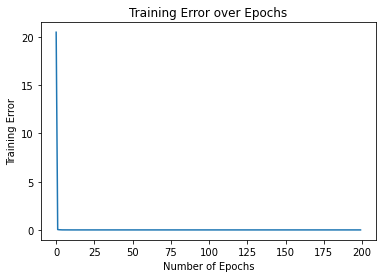

In [63]:
plt.plot(training_loss)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Error")
plt.title("Training Error over Epochs")

In [64]:
linear_model.eval()

linear_nn(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
  )
)

In [65]:
test_input = data_input_tensor[train_size + 1 : ]
test_output = data_output_tensor[train_size + 1 : ]
predicted_output = linear_model(test_input)
loss = loss_fcn(predicted_output,test_output)

test_error = loss.item()
print(f"Test Error: {test_error}")

Test Error: 1.9018876751264457e-11


<span style ="font-family:cursive; font-size: 90%">
Significantly low test error, the trained NN can be used as an approximate model fitting the required transformation
</span>

In [66]:
weight = torch.transpose(linear_model.layers[0].weight, 0, 1)
DFT_matrix = weight[:,0:N] + weight[:,N:2*N]*1j
DFT_matrix

tensor([[ 1.0000+1.1081e-37j,  1.0000-4.6603e-08j,  1.0000+3.8808e-08j,
          1.0000-1.2191e-08j,  1.0000+1.0421e-07j,  1.0000+1.5241e-37j,
          1.0000+2.2398e-08j,  1.0000+4.1601e-09j,  1.0000+1.6635e-08j,
          1.0000+3.8894e-08j],
        [ 1.0000+7.0294e-38j,  0.8090-5.8779e-01j,  0.3090-9.5106e-01j,
         -0.3090-9.5106e-01j, -0.8090-5.8779e-01j, -1.0000+9.6689e-38j,
         -0.8090+5.8779e-01j, -0.3090+9.5106e-01j,  0.3090+9.5106e-01j,
          0.8090+5.8779e-01j],
        [ 1.0000+7.2150e-38j,  0.3090-9.5106e-01j, -0.8090-5.8779e-01j,
         -0.8090+5.8779e-01j,  0.3090+9.5106e-01j,  1.0000+9.9240e-38j,
          0.3090-9.5106e-01j, -0.8090-5.8779e-01j, -0.8090+5.8779e-01j,
          0.3090+9.5106e-01j],
        [ 1.0000+7.4301e-39j, -0.3090-9.5106e-01j, -0.8090+5.8779e-01j,
          0.8090+5.8779e-01j,  0.3090-9.5106e-01j, -1.0000+1.0220e-38j,
          0.3090+9.5106e-01j,  0.8090-5.8779e-01j, -0.8090-5.8779e-01j,
         -0.3090+9.5106e-01j],
        [ 1.

<span style ="font-family:cursive; font-size: 90%">
Since the model is linear, the trained weights essentially give us the DFT matrix for given length N.
</span>

In [67]:
def calculate_DFT(x):
    dft_concat = linear_model(torch.tensor(x)).detach().numpy()
    return dft_concat[0:N] + dft_concat[N:2*N]*1j

<span style ="font-family:cursive; font-size: 90%">
calculate_DFT uses trained NN implementation to calculate DFT of a fixed length input data
</span>